## **0. IMPORTING DEPENDENCIES**

In [30]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import load_img, img_to_array

## **1. DATA INGESTION**

In [31]:
BASE_DIR = "../data/raw/archive"
IMG_DIR = os.path.join(BASE_DIR, "images")
CSV_PATH = os.path.join(BASE_DIR, "GroundTruth.csv")

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

In [32]:
df = pd.read_csv(CSV_PATH)
df.head(3)

,image,MEL,NV,BCC,AKIEC,BKL,DF,VASC
0,ISIC_0024306,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0024307,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0024308,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [33]:
CLASS_NAMES = df.columns[1:].tolist()
NUM_CLASSES = len(CLASS_NAMES)
CLASS_NAMES

['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']

In [34]:
df["label"] = df[CLASS_NAMES].idxmax(axis=1)
df["label_id"] = df[CLASS_NAMES].values.argmax(axis=1)

In [35]:
df["image_path"] = df["image"].apply(
    lambda x: os.path.join(IMG_DIR, f"{x}.jpg")
)

df = df[df["image_path"].apply(os.path.exists)]
df.head()

,image,MEL,NV,BCC,AKIEC,BKL,DF,VASC,label,label_id,image_path
0,ISIC_0024306,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NV,1,../data/raw/archive\images\ISIC_0024306.jpg
1,ISIC_0024307,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NV,1,../data/raw/archive\images\ISIC_0024307.jpg
2,ISIC_0024308,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NV,1,../data/raw/archive\images\ISIC_0024308.jpg
3,ISIC_0024309,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NV,1,../data/raw/archive\images\ISIC_0024309.jpg
4,ISIC_0024310,1.0,0.0,0.0,0.0,0.0,0.0,0.0,MEL,0,../data/raw/archive\images\ISIC_0024310.jpg


## **EDA**

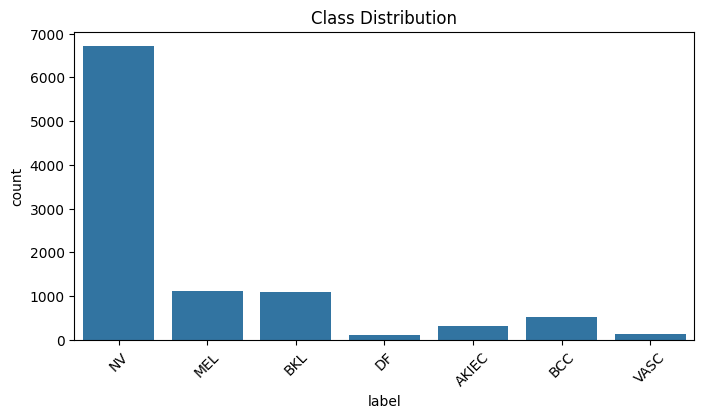

In [36]:
plt.figure(figsize=(8,4))
sns.countplot(x=df["label"])
plt.xticks(rotation=45)
plt.title("Class Distribution")
plt.show()

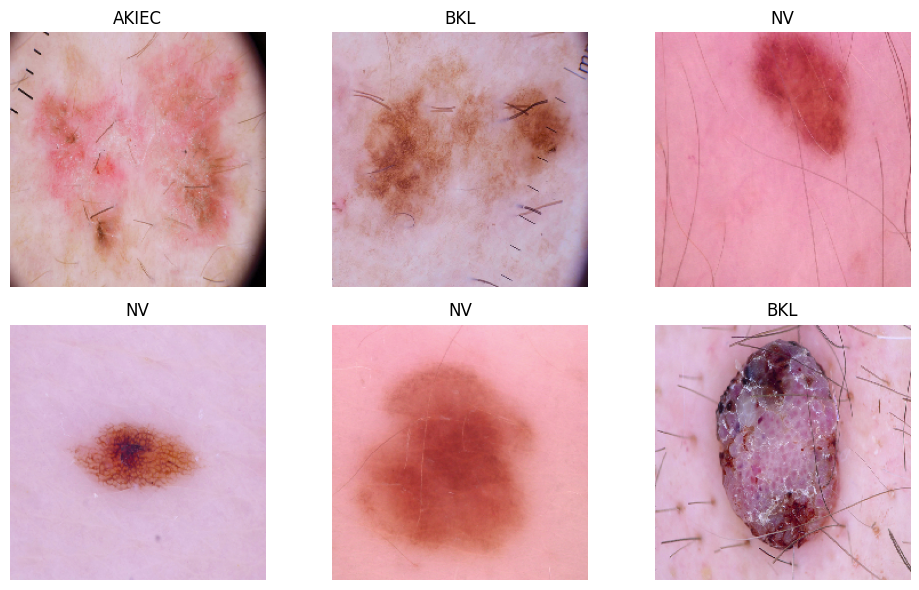

In [37]:
sample_df = df.sample(6)

plt.figure(figsize=(10,6))
for idx, (_, row) in enumerate(sample_df.iterrows()):
    img = load_img(row["image_path"], target_size=IMG_SIZE)
    plt.subplot(2, 3, idx + 1)
    plt.imshow(img)
    plt.title(row["label"])
    plt.axis("off")

plt.tight_layout()
plt.show()


## **TRAIN-TEST VALIDATION**

In [38]:
train_df, val_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df["label_id"],
    random_state=42
)


In [39]:
def load_image(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = img / 255.0
    return img, label


def make_dataset(df):
    paths = df["image_path"].values
    labels = df["label_id"].values

    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    ds = ds.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return ds


train_ds = make_dataset(train_df)
val_ds = make_dataset(val_df)


## **SIMPLE CNN**

In [40]:
model = models.Sequential([
    layers.Conv2D(32, 3, activation="relu", input_shape=(*IMG_SIZE, 3)),
    layers.MaxPooling2D(),

    layers.Conv2D(64, 3, activation="relu"),
    layers.MaxPooling2D(),

    layers.Conv2D(128, 3, activation="relu"),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dense(NUM_CLASSES, activation="softmax")
])

model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


c:\Users\Amith_Kumar2\OneDrive - Dell Technologies\Desktop\PROJECTS\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,863 (42.61 MB)

 Trainable params: 11,169,863 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [41]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)


Epoch 1/10


251/251 ━━━━━━━━━━━━━━━━━━━━ 234s 919ms/step - accuracy: 0.6675 - loss: 1.0181 - val_accuracy: 0.6725 - val_loss: 0.9161
Epoch 2/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 101s 404ms/step - accuracy: 0.6888 - loss: 0.8544 - val_accuracy: 0.6800 - val_loss: 0.8907
Epoch 3/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 114s 454ms/step - accuracy: 0.7106 - loss: 0.7786 - val_accuracy: 0.7069 - val_loss: 0.7872
Epoch 4/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 123s 489ms/step - accuracy: 0.7322 - loss: 0.7295 - val_accuracy: 0.7154 - val_loss: 0.8342
Epoch 5/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 223s 889ms/step - accuracy: 0.7490 - loss: 0.6870 - val_accuracy: 0.7189 - val_loss: 0.7732
Epoch 6/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 157s 623ms/step - accuracy: 0.7640 - loss: 0.6440 - val_accuracy: 0.7109 - val_loss: 0.7875
Epoch 7/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 95s 377ms/step - accuracy: 0.7810 - loss: 0.5985 - val_accuracy: 0.7274 - val_loss: 0.7531
Epoch 8/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 106s 424ms/step - accuracy: 0.7978 - loss: 0.549

## **MODEL EVALUATION**

In [42]:
y_true, y_pred = [], []

for images, labels in val_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/

In [43]:
print(classification_report(
    y_true,
    y_pred,
    target_names=CLASS_NAMES
))


              precision    recall  f1-score   support

         MEL       0.43      0.27      0.33       223
          NV       0.81      0.90      0.85      1341
         BCC       0.44      0.43      0.43       103
       AKIEC       0.33      0.12      0.18        65
         BKL       0.45      0.43      0.44       220
          DF       0.40      0.17      0.24        23
        VASC       0.65      0.61      0.63        28

    accuracy                           0.72      2003
   macro avg       0.50      0.42      0.44      2003
weighted avg       0.69      0.72      0.70      2003



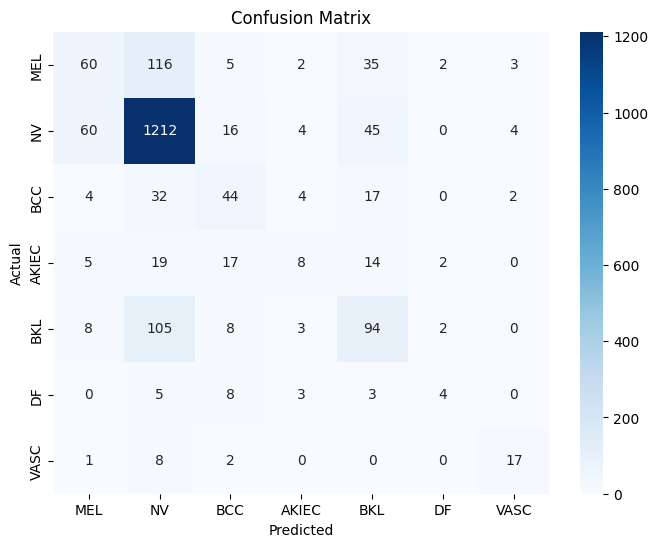

In [44]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=CLASS_NAMES,
    yticklabels=CLASS_NAMES
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [45]:
# model.save("skin_lesion_classifier.keras")


## **MODEL INFERENCE**

In [46]:
def predict_image(img_path, model, class_names):
    img = load_img(img_path, target_size=IMG_SIZE)
    img = img_to_array(img) / 255.0
    img = np.expand_dims(img, axis=0)

    preds = model.predict(img)
    idx = np.argmax(preds)
    return class_names[idx], float(preds[0][idx])


In [49]:
label, conf = predict_image(
    train_df.iloc[66]["image_path"],
    model,
    CLASS_NAMES
)

print(f"Prediction: {label} | Confidence: {conf:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction: BKL | Confidence: 0.92


## **TRANSFER LEARNING**

In [56]:
import numpy as np
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_df["label_id"]),
    y=train_df["label_id"]
)

class_weights = dict(enumerate(class_weights))
class_weights

base_model = VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(*IMG_SIZE, 3)
)

base_model.trainable = False  # freeze backbone

In [57]:
vgg_model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.4),
    layers.Dense(NUM_CLASSES, activation="softmax")
])

vgg_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

vgg_model.summary()


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,847,815 (56.64 MB)

 Trainable params: 133,127 (520.03 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [58]:
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True
)

history_vgg = vgg_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    class_weight=class_weights,
    callbacks=[early_stop]
)


Epoch 1/10
164/251 ━━━━━━━━━━━━━━━━━━━━ 3:30 2s/step - accuracy: 0.2425 - loss: 2.0709

KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(10,5))

plt.plot(history_vgg.history["accuracy"], label="Train Accuracy")
plt.plot(history_vgg.history["val_accuracy"], label="Val Accuracy")

plt.plot(history_vgg.history["loss"], label="Train Loss")
plt.plot(history_vgg.history["val_loss"], label="Val Loss")

plt.xlabel("Epochs")
plt.ylabel("Value")
plt.title("VGG16 Training: Accuracy & Loss")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
y_true, y_pred = [], []

for images, labels in val_ds:
    preds = vgg_model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

print(classification_report(
    y_true,
    y_pred,
    target_names=CLASS_NAMES
))

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=CLASS_NAMES,
    yticklabels=CLASS_NAMES
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("VGG16 Confusion Matrix")
plt.show()

# vgg_model.save("skin_lesion_vgg16.keras")
